# Visual Assesment of Predictions 
**CNN_S3_GAF** (Best performing trader)

***RUN LAST SECTION BY LOADING DATA***

- PCA features 
- 2d t-SNE them
- encode misclassified samples
- append Returns, Predicted probabilities, predictions, labels, date to df.
- __apply K-Means to create groups__
- Visualize as a 3D Scatter plot
- Create Dash App 

__Key__
- x -> misclassified 
- o -> correct 
- colour -> B/S/N probabilities predicted 
- 3rd axis -> returns 


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sqlite3 as sql

# PCA
from statsmodels.multivariate.pca import PCA
from tqdm import tqdm_notebook

# VISUALIZATIONS
import matplotlib as plt
import plotly.express as px



## Final DF. 
Load df from trader

Append pca, t-SNE, cluster groups 
- [x] predictions 
- [x] labels 
- [x] probabilities 
- [x] trading log
- [x] incorrect predictions
- [x] price series
- [ ] pca components 
- [ ] t-SNE groups 
- [ ] cluster groups

In [80]:
conn = sql.connect('FX_data/database.db')
cur = conn.cursor()
df = pd.read_sql_query("SELECT * FROM trade_log_LogisticRegression ",conn)
df['Close'] = df['Price'] # duplibate for trader.One of the features will be scaled. 
df['Prob Buy'] = df['% Buy'] # duplibate for trader.One of the features will be scaled. 
df['Prob Sell'] = df['% Sell'] # duplibate for trader.One of the features will be scaled. 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)
conn.close()


In [81]:
df.head(2)

,Target,Prediction,Correct,% Buy,% Sell,Price,Open,High,Low,Close,Prob Buy,Prob Sell,Balance,Profit
Date,,,,,,,,,,,,,,
2004-03-01,0,1,0,37.25,62.75,0.8034,0.8003,0.8048,0.7971,0.8034,37.25,62.75,9903.846154,-96.153846
2004-03-02,0,0,1,51.20,48.80,0.8184,0.8021,0.8201,0.8017,0.8184,51.20,48.80,9907.401872,3.555718


#### MinMax input features
- use all features [Prediction	% Buy	% Sell	Price	Open	High	Low]
- scale all except categprical (Prediction)

In [82]:
features_to_scale = df[['Prob Buy','Prob Sell','Open','High','Low','Close']]

In [83]:
# Scale continuous independent variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_to_scale), columns = features_to_scale.columns)
# Replace in df
df[['Prob Buy','Prob Sell','Open','High','Low','Close']] = features_scaled.values
print(scaler.data_max_)
df.head(2)

[98.24   97.72    0.8569  0.8591  0.8524  0.8568]


,Target,Prediction,Correct,% Buy,% Sell,Price,Open,High,Low,Close,Prob Buy,Prob Sell,Balance,Profit
Date,,,,,,,,,,,,,,
2004-03-01,0,1,0,37.25,62.75,0.8034,0.755824,0.762779,0.758515,0.769330,0.364423,0.635577,9903.846154,-96.153846
2004-03-02,0,0,1,51.20,48.80,0.8184,0.763589,0.829620,0.778603,0.834125,0.509796,0.490204,9907.401872,3.555718


In [85]:
df[['Prob Buy','Prob Sell','Open','High','Low','Close']].tail(2)

,Prob Buy,Prob Sell,Open,High,Low,Close
Date,,,,,,
2009-12-31,0.321697,0.678303,0.311475,0.300568,0.300873,0.316199
2010-01-01,0.146519,0.853481,0.314495,0.297510,0.324454,0.314471


#### PCA

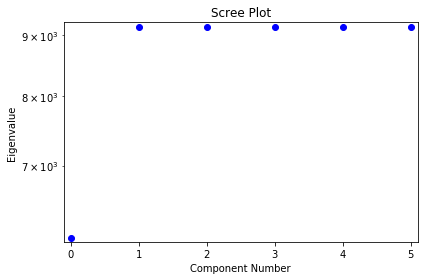

In [86]:
pca = PCA(df[['Prob Buy','Prob Sell','Open','High','Low','Close']], ncomp=6 ) 
"""
Used to determine the number of factors to retain in an exploratory factor analysis 
or principal components to keep in a principal component analysis
"""
pca.plot_scree(6,cumulative=True);

In [87]:
pca = PCA(df[['Prob Buy','Prob Sell','Open','High','Low','Close']], ncomp=2 )

In [88]:
#df2 = pd.concat([df, pd.DataFrame(pca.scores).iloc[:,:3]],axis=1)

from sklearn.manifold import TSNE
import time
random_state = 100

time_start = time.time()
for i in tqdm_notebook(range(1, 2)):
    df_tsne = TSNE(n_components=2,    # 2 NEW COMPONENTS TO BE CREATED
                   random_state=random_state).fit_transform(pca.scores)
df_tsne = pd.DataFrame(df_tsne,columns = ["t-SNE_1","t-SNE_2"],index=df.index)
print (("t-SNE completed after %f seconds")%(time.time()-time_start))


t-SNE completed after 37.339957 seconds


In [89]:
#### Combine PCA and t-SNE features
df = pd.concat([df,pca.scores,df_tsne],axis=1)
df.head(3)

,Target,Prediction,Correct,% Buy,% Sell,Price,Open,High,Low,Close,Prob Buy,Prob Sell,Balance,Profit,comp_0,comp_1,t-SNE_1,t-SNE_2
Date,,,,,,,,,,,,,,,,,,
2004-03-01,0,1,0,37.25,62.75,0.8034,0.755824,0.762779,0.758515,0.769330,0.364423,0.635577,9903.846154,-96.153846,-0.019401,0.017532,22.393435,-12.548299
2004-03-02,0,0,1,51.20,48.80,0.8184,0.763589,0.829620,0.778603,0.834125,0.509796,0.490204,9907.401872,3.555718,-0.023871,-0.001502,8.196338,-28.824339
2004-03-03,0,1,0,22.13,77.87,0.8190,0.833477,0.870249,0.848908,0.836717,0.206857,0.793143,9901.113716,-6.288156,-0.027337,0.038859,39.148609,-18.610426


#### Apply K-means on PCA ouputs 
- Should not apply K-means to t-SNE outputs directly, because [algo preserves no distance nor density](https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne).
- These groups may not be accurate when visualized with tSNE

In [90]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

# Calculating the sum of squared distances from each point 
# to its assigned center(distortions).
inertia = []
for k in tqdm_notebook(range(1, 15)): # Just 3 classes, but try up to 15
    kmeans = KMeans(n_clusters=k, n_init=100, 
                    random_state=random_state, n_jobs=1).fit(pca.scores)
    inertia.append(np.sqrt(kmeans.inertia_))
    
 

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

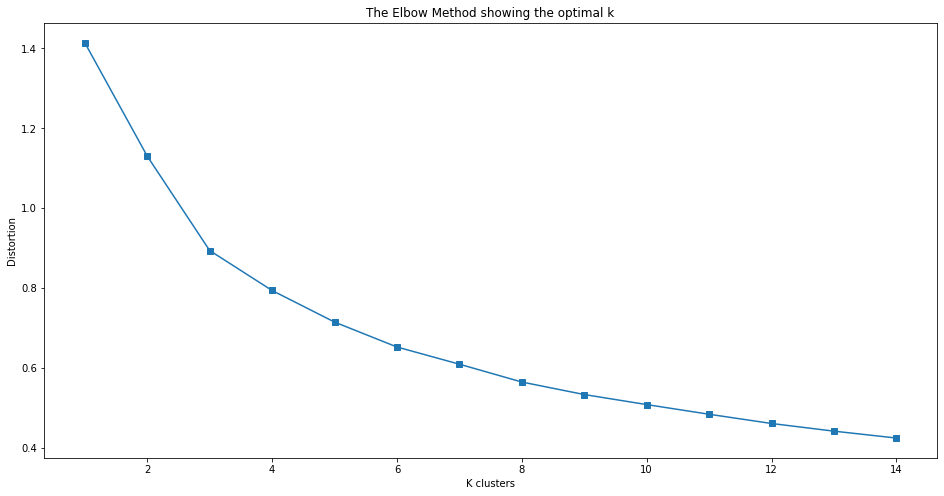

In [91]:
import matplotlib.pyplot as plt
# Elbow plot
plt.figure(figsize=(16,8))
plt.plot(range(1, 15), inertia, marker='s');
plt.xlabel('K clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')   

In [92]:
# From 
optimal_no_cluster =10  # Subjective --> want to enough subgroups to differentiate behaviour, but large enough to trade

##### Run K-mean with optimal cluster count 

In [97]:
kmeans = KMeans(n_clusters= optimal_no_cluster, 
                n_init=100, 
                random_state=random_state, 
                n_jobs=1)
kmeans.fit(pca.scores)

# Append clusters to df 
df['Cluster'] =kmeans.labels_
df.head(2)

,Target,Prediction,Correct,% Buy,% Sell,Price,Open,High,Low,Close,Prob Buy,Prob Sell,Balance,Profit,comp_0,comp_1,t-SNE_1,t-SNE_2,Cluster
Date,,,,,,,,,,,,,,,,,,,
2004-03-01,0,1,0,37.25,62.75,0.8034,0.755824,0.762779,0.758515,0.769330,0.364423,0.635577,9903.846154,-96.153846,-0.019401,0.017532,22.393435,-12.548299,5
2004-03-02,0,0,1,51.20,48.80,0.8184,0.763589,0.829620,0.778603,0.834125,0.509796,0.490204,9907.401872,3.555718,-0.023871,-0.001502,8.196338,-28.824339,5


#### Save Data 

In [122]:
df['Confidence %'] = df[['% Buy','% Sell']].max(axis=1)

conn = sql.connect('FX_data/database.db')
cur = conn.cursor()
df.to_sql("eda_data_LR",conn,if_exists='replace')
conn.close()

C:\Users\09ale\Anaconda3\lib\site-packages\pandas\core\generic.py:2712: UserWarning:

The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.



## 3d Scatter plot

In [123]:
conn = sql.connect('FX_data/database.db')
cur = conn.cursor()
df = pd.read_sql_query("SELECT * FROM eda_data_LR ",conn)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)
conn.close()

df.head(2)

,Target,Prediction,Correct,% Buy,% Sell,Price,Open,High,Low,Close,Prob Buy,Prob Sell,Balance,Profit,comp_0,comp_1,t-SNE_1,t-SNE_2,Cluster,Confidence %
Date,,,,,,,,,,,,,,,,,,,,
2004-03-01,0,1,0,37.25,62.75,0.8034,0.755824,0.762779,0.758515,0.769330,0.364423,0.635577,9903.846154,-96.153846,-0.019401,0.017532,22.393435,-12.548299,5,62.75
2004-03-02,0,0,1,51.20,48.80,0.8184,0.763589,0.829620,0.778603,0.834125,0.509796,0.490204,9907.401872,3.555718,-0.023871,-0.001502,8.196338,-28.824339,5,51.20


#### PCA Vizualization of trades

In [136]:
fig = px.scatter_3d(df, # .astype(str) makes the colour map discrete
                         x='comp_0',#"t-SNE_1", 
                         y='comp_1',#"t-SNE_2",
                         z="Profit", 
                         color="Confidence %",
                         color_continuous_scale='Inferno',
#                              size = 'variable',   #size='petal_length', hover_data=['petal_width'])
#                              size_max = 10,
                         hover_name= "Correct",
                         #text = df2['Predictions'],df2['Correct'],df2['Date'],
                         hover_data = ['Profit','Cluster','Confidence %'],   #pd.DataFrame(pca.projection), #, 'mean texture', 'mean perimeter', 
                                         #'mean area','mean smoothness']],
                         title = " 2 Main PCs ",
#                          width = 1000,
#                          height = 1000,
                        )
fig.write_image("images/PCA_draft.png") # $ conda install -c plotly plotly-orca psutil requests
fig.show()

#### t-SNE visualisation of trades

In [137]:
fig = px.scatter_3d(df, # .astype(str) makes the colour map discrete
                         x= "t-SNE_1", 
                         y= "t-SNE_2",
                         z="Profit", 
                         color="Confidence %",
                         color_continuous_scale='Inferno',
#                              size = 'variable',   #size='petal_length', hover_data=['petal_width'])
#                              size_max = 10,
                         hover_name= "Correct",
                         #text = df2['Predictions'],df2['Correct'],df2['Date'],
                         hover_data = ['Profit','Cluster','Confidence %'],   #pd.DataFrame(pca.projection), #, 'mean texture', 'mean perimeter', 
                                         #'mean area','mean smoothness']],
                         title = " 2 Main t-SNE Components ",
#                          width = 1000,
#                          height = 1000,
                        )
fig.write_image("images/tSNE_draft.png") # $ conda install -c plotly plotly-orca psutil requests         
fig.show()

======================================   END  ========================================